In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [126]:
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.accuracy import rmse
from surprise import accuracy
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering

In [127]:
import sqlite3

conn = sqlite3.connect('../db.sqlite3')

In [128]:
FETCH_BOOK_QUERY = "SELECT `id`, `title`, `publisher`, `author`, `image`, `category_id`, `available` FROM `libraryapp_book` "

book_list = pd.read_sql_query(FETCH_BOOK_QUERY, conn)
book_list.head()

,id,title,publisher,author,image,category_id,available
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0
1,6,DBA,ram,thapa,book/pos6.jpg,2,1
2,7,cryptography,ram,thapa,book/baag.jpg,1,1
3,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7
4,9,Harry Potter and the Philosopher's Stone,Harper Collins Collins,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...,4,24


In [129]:
book_list.count()

id             205
title          205
publisher      205
author         205
image          205
category_id    205
available      205
dtype: int64

In [130]:
# rename book list dataframe columns
books = book_list.rename(
    {'id': 'book_id', 'title': 'book_title', 'image': 'book_image'}, axis=1)
books

,book_id,book_title,publisher,author,book_image,category_id,available
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0
1,6,DBA,ram,thapa,book/pos6.jpg,2,1
2,7,cryptography,ram,thapa,book/baag.jpg,1,1
3,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7
4,9,Harry Potter and the Philosopher's Stone,Harper Collins Collins,"J.K. Rowling, Mary GrandPré",https://images.gr-assets.com/books/1474154022m...,4,24
...,...,...,...,...,...,...,...
200,205,"The Devil in the White City: Murder, Magic, an...",New Directions,"Erik Larson, Tony Goldwyn",https://images.gr-assets.com/books/1312066724m...,3,47
201,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26
202,207,The Chronicles of Narnia,Penguin Books Ltd. (London),"C.S. Lewis, Pauline Baynes",https://images.gr-assets.com/books/1449868701m...,3,30
203,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49


In [131]:
books_category = pd.read_sql_query("SELECT `id` as `category_id`, `title` as `category_title`, `image` as `category_image` FROM `libraryapp_bookcategory`", conn)

books_category.head()

,category_id,category_title,category_image
0,1,interseting,bookcategory/download.jpeg
1,2,educational,bookcategory/e1.jpg
2,3,Fiction,https://www.google.com/url?sa=i&url=https%3A%2...
3,4,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...


In [132]:
# merge books and book_category
books_data = pd.merge(books, books_category, on='category_id')
books_data

,book_id,book_title,publisher,author,book_image,category_id,available,category_title,category_image
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg
1,6,DBA,ram,thapa,book/pos6.jpg,2,1,educational,bookcategory/e1.jpg
2,209,Networking,Pearson,Unknown,book/alone-tree-sunset-qe.jpg,2,3,educational,bookcategory/e1.jpg
3,7,cryptography,ram,thapa,book/baag.jpg,1,1,interseting,bookcategory/download.jpeg
4,8,The Hunger Games,Harper Collins Collins,Suzanne Collins,https://images.gr-assets.com/books/1447303603m...,3,7,Fiction,https://www.google.com/url?sa=i&url=https%3A%2...
...,...,...,...,...,...,...,...,...,...
200,197,One for the Money,Penguin Books,Janet Evanovich,https://images.gr-assets.com/books/1316730230m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
201,202,Die Verwandlung,Penguin Books,"Franz Kafka, Stanley Corngold",https://images.gr-assets.com/books/1359061917m...,4,6,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
202,203,The Titan's Curse,Henry Holt & Company,Rick Riordan,https://images.gr-assets.com/books/1361038385m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...
203,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...


In [133]:
book_ratings = pd.read_sql_query("SELECT `id`, `rating`, `book_id`, `user_id` from `libraryapp_bookrating` ", conn)
book_ratings.head()

,id,rating,book_id,user_id
0,1,3,5,5
1,2,4,5,6
2,3,4,6,6
3,4,4,5,6
4,5,3,5,5


## Merge boo_list and book_ratings

In [134]:
books_with_rating = pd.merge(books_data, book_ratings, on='book_id')
books_with_rating

,book_id,book_title,publisher,author,book_image,category_id,available,category_title,category_image,id,rating,user_id
0,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,1,3,5
1,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,2,4,6
2,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,4,4,6
3,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,5,3,5
4,5,DAA,suman,suuman,book/02_-_Python_e_Django.jpg.250x250_q85_crop...,2,0,educational,bookcategory/e1.jpg,6,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...
238,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,194,4,8
239,206,Bared to You,Actes Sud,Sylvia Day,https://images.gr-assets.com/books/1477803272m...,4,26,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,207,5,7
240,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,56,4,6
241,208,Twilight: The Complete Illustrated Movie Compa...,Business Plus,Mark Cotta Vaz,https://images.gr-assets.com/books/1352539022m...,4,49,Fantasy,https://www.google.com/url?sa=i&url=https%3A%2...,233,4,8


In [135]:
books_with_rating.groupby('book_title')['rating'].count()

book_title
 The Fellowship of the Ring                                   2
A Christmas Carol                                             2
A Clockwork Orange                                            1
A Feast for Crows                                             2
A Game of Thrones                                             2
                                                             ..
Where the Wild Things Are                                     3
Wicked: The Life and Times of the Wicked Witch of the West    1
Wuthering Heights                                             1
cryptography                                                  4
Анна Каренина                                                 2
Name: rating, Length: 131, dtype: int64

In [136]:
ratings = pd.DataFrame(books_with_rating.groupby('book_title')['rating'].mean())
ratings['total_rating'] = pd.DataFrame(books_with_rating.groupby('book_title')['rating'].count())
ratings

,rating,total_rating
book_title,,
The Fellowship of the Ring,4.500000,2
A Christmas Carol,3.000000,2
A Clockwork Orange,4.000000,1
A Feast for Crows,4.000000,2
A Game of Thrones,3.000000,2
...,...,...
Where the Wild Things Are,4.666667,3
Wicked: The Life and Times of the Wicked Witch of the West,5.000000,1
Wuthering Heights,5.000000,1


## Data Preparation

In [137]:
ratings

,rating,total_rating
book_title,,
The Fellowship of the Ring,4.500000,2
A Christmas Carol,3.000000,2
A Clockwork Orange,4.000000,1
A Feast for Crows,4.000000,2
A Game of Thrones,3.000000,2
...,...,...
Where the Wild Things Are,4.666667,3
Wicked: The Life and Times of the Wicked Witch of the West,5.000000,1
Wuthering Heights,5.000000,1


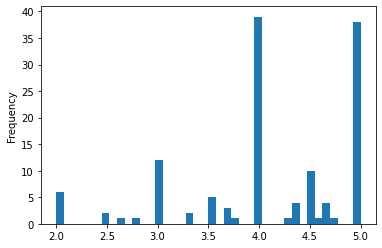

In [138]:
ratings['rating'].plot.hist(bins=40);

In [139]:
user_rating = books_with_rating.groupby('user_id')['rating'].count().clip(upper=50)
user_rating

user_id
5     39
6     50
7     50
8     47
9     45
10     5
11     2
12     1
13     1
14     1
Name: rating, dtype: int64

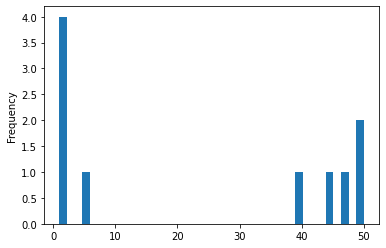

In [140]:
user_rating.plot.hist(bins=40);

# Into Collaborative Filtering
***

Filter Data to reduce Dimensionality

In [141]:
# Minimum book rating to add  that book in books_data.
min_book_rating = 1
filter_books = books_with_rating['book_title'].value_counts() >= min_book_rating
filter_books = filter_books[filter_books].index.tolist()

#  at least user should should rate 2 books to be added
MIN_USER_RATING = 2
filter_users = books_with_rating['user_id'].value_counts() >= MIN_USER_RATING
filter_users = filter_users[filter_users].index.tolist()

books_data = books_with_rating[books_with_rating['book_title'].isin(filter_books) & 
    (books_with_rating['user_id'].isin(filter_users))]
print("Original Shape: {}".format(books_with_rating.shape))
print("Filter Data Shape: {}".format(books_data.shape))
books_data.describe()

Original Shape: (243, 12)
Filter Data Shape: (240, 12)


,book_id,category_id,available,id,rating,user_id
count,240.000000,240.000000,240.000000,240.00000,240.000000,240.000000
mean,102.987500,3.450000,24.412500,120.50000,4.095833,7.125000
std,64.275914,0.657751,15.089713,69.42622,1.003750,1.458276
min,5.000000,1.000000,0.000000,1.00000,1.000000,5.000000
25%,40.500000,3.000000,12.000000,60.75000,4.000000,6.000000
50%,103.000000,4.000000,24.000000,120.50000,4.000000,7.000000
75%,158.500000,4.000000,37.000000,180.25000,5.000000,8.000000
max,208.000000,4.000000,50.000000,240.00000,5.000000,11.000000


## Surprise Library
Load data from `books_data` dataframe to surprise Reader

In [142]:
reader = Reader(rating_scale=(0, 9))
data = Dataset.load_from_df(books_data[['user_id', 'book_title', 'rating']], reader)

Check RMSE, MAE for different algorithms to find best suitable model

In [143]:
benchmark = []
# Iterate over all algorithms
# KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
# NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, SlopeOne, CoClustering
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9593  0.8563  1.1664  0.9940  0.1289  
MAE (testset)     0.7581  0.6828  0.8546  0.7652  0.0703  
Fit time          0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9069  1.0281  1.0873  1.0075  0.0751  
MAE (testset)     0.6983  0.7942  0.8206  0.7710  0.0525  
Fit time          0.08    0.07    0.08    0.08    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    
Evaluating RMSE, MAE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1194  1.3048  1.2632  1.2292  0.0794  
MAE (testset)     0.8882  0.9960  0.9996  0.9613  0.0517  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test 

In [144]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.994010,0.765161,0.012237,0.000871
BaselineOnly,0.995537,0.754896,0.000573,0.000381
SVDpp,1.007451,0.771008,0.077930,0.002734
KNNBasic,1.115576,0.768808,0.000178,0.000650
KNNWithZScore,1.164775,0.883198,0.000813,0.000811
KNNBaseline,1.173808,0.867848,0.000779,0.000773
CoClustering,1.181831,0.851559,0.013393,0.000422
KNNWithMeans,1.186565,0.864074,0.000461,0.000870
SlopeOne,1.229150,0.961292,0.000466,0.001437


From Above, we can see SVD is more suitable in our dataset as it has less RMSE.

# Singular Value Decomposition (SVD)
***


## Train & Predict

In [160]:
# print('Using ALS')
# bsl_options = {'method': 'als',
#                'n_epochs': 5,
#                'reg_u': 12,
#                'reg_i': 5
#                }
# algo = SVD(bsl_options=bsl_options)
# cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

In [162]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.20)

algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8979


0.8978549256853974

In [163]:
def get_item_rated_by_user(user_id):
    """ return the number of items rated by given user
    args: 
      user_id: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(user_id)])
    except ValueError: # user was not part of the trainset
        return 0

def get_users_rated_on_item(item_id):
    """ return number of users that have rated given item
    args:
      item_id: the raw id of the item
    returns:a
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(item_id)])
    except ValueError:
        return 0


predictions_data = pd.DataFrame(predictions, columns=['user_id', 'book_title', 'rui', 'est', 'details'])
predictions_data['item_rated_by_user'] = predictions_data.user_id.apply(get_item_rated_by_user)
predictions_data['users_rated_on_item'] = predictions_data.book_title.apply(get_users_rated_on_item)
predictions_data['err'] = abs(predictions_data.est - predictions_data.rui)

In [164]:
predictions_data.head()

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
0,7,The Lost Hero,4.0,4.098588,{'was_impossible': False},38,1,0.098588
1,9,Atonement,2.0,4.286344,{'was_impossible': False},34,0,2.286344
2,9,Memoirs of a Geisha,5.0,4.286344,{'was_impossible': False},34,0,0.713656
3,8,Luftslottet som sprängdes,5.0,4.135046,{'was_impossible': False},34,0,0.864954
4,7,The Bell Jar,4.0,3.963220,{'was_impossible': False},38,0,0.036780


In [165]:
# def get_Iu(uid):
#     """ return the number of items rated by given user
#     args: 
#       uid: the id of the user
#     returns: 
#       the number of items rated by the user
#     """
#     try:
#         return len(trainset.ur[trainset.to_inner_uid(uid)])
#     except ValueError: # user was not part of the trainset
#         return 0
    
# def get_Ui(iid):
#     """ return number of users that have rated given item
#     args:
#       iid: the raw id of the item
#     returns:
#       the number of users that have rated the item.
#     """
#     try: 
#         return len(trainset.ir[trainset.to_inner_iid(iid)])
#     except ValueError:
#         return 0
    
# df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
# df['Iu'] = df.uid.apply(get_Iu)
# df['Ui'] = df.iid.apply(get_Ui)
# df['err'] = abs(df.est - df.rui)
# df['err'] = abs(df.est - df.rui)

In [166]:
# df.head()

In [167]:
best_predictions = predictions_data.sort_values(by='err')[:10]
worst_predictions = predictions_data.sort_values(by='err')[-10:]


In [168]:
best_predictions

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
14,6,The Lord of the Rings,4.0,3.997653,{'was_impossible': False},44,2,0.002347
44,11,The Titan's Curse,4.0,3.975192,{'was_impossible': False},1,0,0.024808
40,7,Atonement,4.0,3.963220,{'was_impossible': False},38,0,0.036780
4,7,The Bell Jar,4.0,3.963220,{'was_impossible': False},38,0,0.036780
5,8,Bared to You,4.0,4.071062,{'was_impossible': False},34,2,0.071062
36,7,The Girl on the Train,4.0,4.081298,{'was_impossible': False},38,1,0.081298
0,7,The Lost Hero,4.0,4.098588,{'was_impossible': False},38,1,0.098588
19,10,Harry Potter and the Philosopher's Stone,4.0,4.118469,{'was_impossible': False},4,1,0.118469
13,8,Green Eggs and Ham,4.0,4.123374,{'was_impossible': False},34,1,0.123374
32,9,Animal Farm: A Fairy Story,4.0,4.132242,{'was_impossible': False},34,1,0.132242


In [169]:
worst_predictions

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
26,7,The Poisonwood Bible,5.0,3.907525,{'was_impossible': False},38,4,1.092475
33,8,Gone with the Wind,3.0,4.135046,{'was_impossible': False},34,0,1.135046
37,6,The Road,5.0,3.849466,{'was_impossible': False},44,0,1.150534
41,6,Allegiant,5.0,3.849466,{'was_impossible': False},44,0,1.150534
38,9,The Handmaid's Tale,3.0,4.221904,{'was_impossible': False},34,2,1.221904
18,7,Beautiful Creatures,5.0,3.707809,{'was_impossible': False},38,2,1.292191
20,9,"New Moon (Twilight, #2)",3.0,4.422458,{'was_impossible': False},34,1,1.422458
34,6,The Hobbit or There and Back Again,2.0,3.849466,{'was_impossible': False},44,0,1.849466
22,8,Great Expectations,2.0,4.095797,{'was_impossible': False},34,2,2.095797
1,9,Atonement,2.0,4.286344,{'was_impossible': False},34,0,2.286344


In [173]:
predictions_data[predictions_data['est'] < 4]

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
4,7,The Bell Jar,4.0,3.963220,{'was_impossible': False},38,0,0.036780
12,6,It,5.0,3.936835,{'was_impossible': False},44,2,1.063165
14,6,The Lord of the Rings,4.0,3.997653,{'was_impossible': False},44,2,0.002347
16,5,The Hunger Games,3.0,3.938515,{'was_impossible': False},37,2,0.938515
18,7,Beautiful Creatures,5.0,3.707809,{'was_impossible': False},38,2,1.292191
23,6,The Immortal Life of Henrietta Lacks,4.0,3.849466,{'was_impossible': False},44,0,0.150534
26,7,The Poisonwood Bible,5.0,3.907525,{'was_impossible': False},38,4,1.092475
30,6,Catching Fire,4.0,3.847333,{'was_impossible': False},44,2,0.152667
34,6,The Hobbit or There and Back Again,2.0,3.849466,{'was_impossible': False},44,0,1.849466
37,6,The Road,5.0,3.849466,{'was_impossible': False},44,0,1.150534


In [174]:
predictions_data[predictions_data['rui'] < 3]

,user_id,book_title,rui,est,details,item_rated_by_user,users_rated_on_item,err
1,9,Atonement,2.0,4.286344,{'was_impossible': False},34,0,2.286344
22,8,Great Expectations,2.0,4.095797,{'was_impossible': False},34,2,2.095797
34,6,The Hobbit or There and Back Again,2.0,3.849466,{'was_impossible': False},44,0,1.849466


In [171]:
books_data.loc[books_data['book_title'] == "DAA"]['rating']

0    3
1    4
2    4
3    3
4    4
5    4
Name: rating, dtype: int64

(240, 12)